# <span style="color:red"> Laboratorio di Simulazione Numerica (NSL) </span>
## <span style="color:blue">  Esercitazione 7 </span>

In questa esercitazione utilizzeremo il codice Monte Carlo ``Monte_Carlo_NVT`` per effettuare delle simulazioni di un insieme di particelle di Argon in varie fasi termodinamiche. Tutte le simulazioni sono svolte nell'ensemble *canonico* (***NVT***) in cui la temperatura $T$ è costante. Andremo a misurare l'energia potenziale per particella $U/N$ e la pressione $P$ del sistema. 

Il codice implementa *condizioni periodiche al contorno* (***PBC***) e utilizza *unità Lennard-Jones* ($LJ$) (v. *Esercitazione 4*). Viene sfruttato l'algoritmo di Metropolis per campionare il peso di Boltzmann con cui generare ogni nuova configurazione del sistema ad ogni *step*.

Con i dati prodotti dal codice, effettueremo inoltre delle analisi sulla funzione di autocorrelazione $ACF$ e sull'errore statistico, per determinare informazioni sul metodo di *data blocking*.

Infine, implementermo il calcolo della funzione di distribuzione radiale $g(r)$ sia nel codice ``Monte_Carlo_NVT`` che in quello ``MolDyn_NVE`` di dinamica molecolare (v. *Esercitazione 4*) e andremo a confrontare i risultati ottenuti con i due codici.

### Esercizio 07.1
Utilizzando il codice ``Monte_Carlo_NVT``, produciamo $M=5\times10^5$ valori di energia potenziale per particella $U/N$ e pressione $P$, per ognuna delle simulazioni con i seguenti parametri termodinamici:

- Fase solida: $\rho^\star = 1.1$, $T^\star = 0.8$ (raggio di cut-off: $r_c = 2.2$)
- Fase liquida: $\rho^\star = 0.8$, $T^\star = 1.1$ (raggio di cut-off: $r_c = 2.5$)
- Fase gassosa: $\rho^\star = 0.05$, $T^\star = 1.2$ (raggio di cut-off: $r_c = 5.0$)

dove $\rho^\star$ e $T^\star$ sono temperatura e densità in unità $LJ$. Vogliamo calcolare per ciascuno di questi data-set la funzione di autocorrelazione $ACF$: questa ci da un'indicazione su quale sia il tempo di correlazione $t_c$ (in questo caso, uno step temporale corripsonde ad uno step Monte Carlo), il tempo neccessario al sistema per passare da uno stato ad un altro significativamente diverso. Questa informazione è utile pr il metodo di *data blocking*, in quanto ci dice quanto devono essere grandi i blocchi per avere una bassa correlazione.

Di seguito riportiamo i risultati ottenuti; la $ACF$ (normalizzata) è calcolata con l'ausilio del modulo ``statsmodels.tsa.stattools``, ed è riportata in funzione dello step temporale $t$.

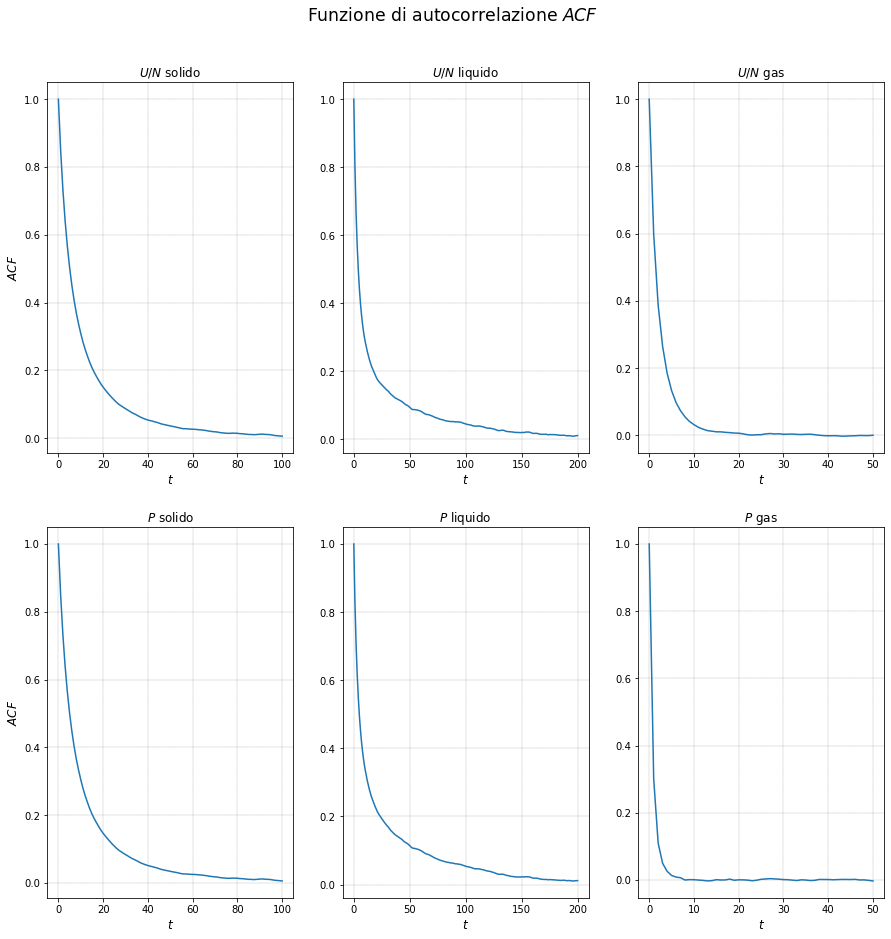

In [1]:
#ACF

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math

from statsmodels.tsa import stattools as st #Funzione di autocorrelazione
                                                                
M = int(5e5)
                                                                    
# Load epot files
epot_solid = np.loadtxt("07.1/solid/Data/output.epot.instant")
epot_liquid = np.loadtxt("07.1/liquid/Data/output.epot.instant")
epot_gas = np.loadtxt("07.1/gas/Data/output.epot.instant")

# Load pres files
pres_solid = np.loadtxt("07.1/solid/Data/output.pres.instant")
pres_liquid = np.loadtxt("07.1/liquid/Data/output.pres.instant")
pres_gas = np.loadtxt("07.1/gas/Data/output.pres.instant")
    

fig1, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,15))
fig1.suptitle(r"Funzione di autocorrelazione $ACF$", fontsize="xx-large",y=0.95)

axs[0,0].plot(st.acf(epot_solid, nlags=100,fft=True))
axs[0,1].plot(st.acf(epot_liquid, nlags=200,fft=True))
axs[0,2].plot(st.acf(epot_gas, nlags=50,fft=True))
axs[1,0].plot(st.acf(pres_solid, nlags=100,fft=True))
axs[1,1].plot(st.acf(pres_liquid, nlags=200,fft=True))
axs[1,2].plot(st.acf(pres_gas,nlags=50,fft=True))

axs[0,0].set_xlabel(r"$t$", fontsize="large")
axs[0,1].set_xlabel(r"$t$", fontsize="large")
axs[0,2].set_xlabel(r"$t$", fontsize="large")
axs[1,0].set_xlabel(r"$t$", fontsize="large")
axs[1,1].set_xlabel(r"$t$", fontsize="large")
axs[1,2].set_xlabel(r"$t$", fontsize="large")

axs[0,0].set_ylabel(r"$ACF$", fontsize="large")
axs[1,0].set_ylabel(r"$ACF$", fontsize="large")

axs[0,0].set_title(r"$U/N$ solido", fontsize="large")
axs[0,1].set_title(r"$U/N$ liquido", fontsize="large")
axs[0,2].set_title(r"$U/N$ gas", fontsize="large")
axs[1,0].set_title(r"$P$ solido", fontsize="large")
axs[1,1].set_title(r"$P$ liquido", fontsize="large")
axs[1,2].set_title(r"$P$ gas", fontsize="large")

axs[0,0].grid(True, linestyle="--", linewidth=0.2, color='.25', zorder=-10)
axs[0,1].grid(True, linestyle="--", linewidth=0.2, color='.25', zorder=-10)
axs[0,2].grid(True, linestyle="--", linewidth=0.2, color='.25', zorder=-10)
axs[1,0].grid(True, linestyle="--", linewidth=0.2, color='.25', zorder=-10)
axs[1,1].grid(True, linestyle="--", linewidth=0.2, color='.25', zorder=-10)
axs[1,2].grid(True, linestyle="--", linewidth=0.2, color='.25', zorder=-10)


plt.show()


In tutti casi, è visibile il caratteristico crollo a zero della autocorrelazione, dopo un sufficente numero di step. Il crollo è molto rapido nel caso del gas, dopo meno di una decina di step. E' possibile quindi capire quali siano le dimensioni minime dei blocchi in ogni simulazione per non avere correlazioni significative.

Vogliamo usare gli stessi dati per andare a studiare l'andamento dell'errore in funzione della larghezza dei blocchi. Andiamo a suddividere il data-set in $N$ blocchi di lunghezza $L$, che facciamo variare nell'intervallo $[10,5000]$. Calcoliamo i valori medi in ogni blocco, che mediamo nuovamente su tutti gli $N$ blocchi. La deviazione standard su quest'ultimo valore rappresenta l'errore statistico che andiamo a graficare.

I grafici che seguono mostrano l'andamento dell'errore in funzione di $L$. 

In [43]:
def error(AV,AV2,n):
    if n==0:
        return 0
    else:
        return math.sqrt((AV2[n] - AV[n]**2)/n)
    
def block_err(data, M, L):                         
     
    N=int(M/L)    
    x = np.arange(N)
    ave = np.zeros(N)
    av2 = np.zeros(N)
    mean = 0.0
    mean2 = 0.0
    err = 0.0

    for i in range(N):
        sum = 0
        for j in range(L):
            k = j+i*L
            sum += data[k]
        ave[i] = sum/L       
        av2[i] = (ave[i])**2 

        mean += ave[i]
        mean2 += av2[i]
        
    mean /= N
    mean2 /= N
    
    if(N==0):
        return 0
    else:
        err = math.sqrt((mean2 - mean**2)/N)
        return err

    
    
M = int(5e5)
N = int(M/L)
S=5000


epot_err_solid = np.zeros(S)
epot_err_liquid = np.zeros(S)
epot_err_gas = np.zeros(S)
pres_err_solid = np.zeros(S)
pres_err_liquid = np.zeros(S)
pres_err_gas = np.zeros(S)

for i in range(10,S):
    epot_err_solid[i] = block_err(epot_solid, M, i)
    epot_err_liquid[i] = block_err(epot_liquid, M, i)
    epot_err_gas[i] = block_err(epot_gas, M, i)
    pres_err_solid[i] = block_err(pres_solid, M, i)
    pres_err_liquid[i] = block_err(pres_liquid, M, i)
    pres_err_gas[i] = block_err(pres_gas, M, i)


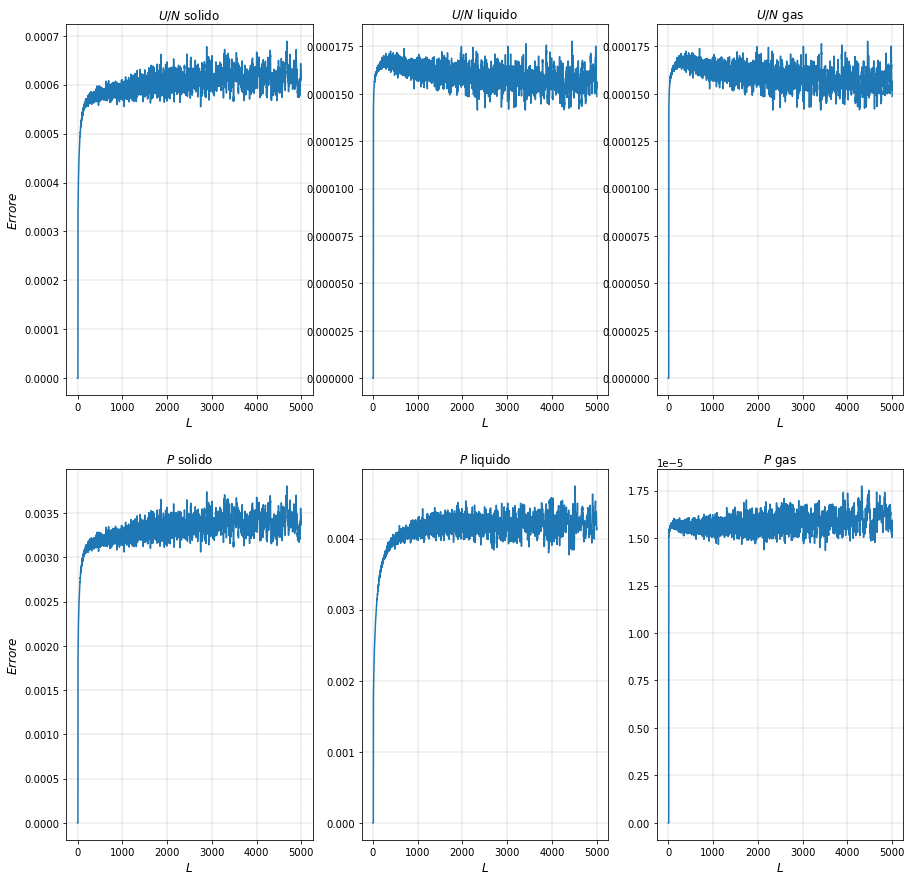

In [49]:
fig2, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,15))
fig1.suptitle(r"Andamento dell'errore statistico", fontsize="xx-large",y=0.95)

axs[0,0].plot(epot_err_solid)
axs[0,1].plot(epot_err_liquid)
axs[0,2].plot(epot_err_gas)
axs[1,0].plot(pres_err_solid)
axs[1,1].plot(pres_err_liquid)
axs[1,2].plot(pres_err_gas)

axs[0,0].set_xlabel(r"$L$", fontsize="large")
axs[0,1].set_xlabel(r"$L$", fontsize="large")
axs[0,2].set_xlabel(r"$L$", fontsize="large")
axs[1,0].set_xlabel(r"$L$", fontsize="large")
axs[1,1].set_xlabel(r"$L$", fontsize="large")
axs[1,2].set_xlabel(r"$L$", fontsize="large")

axs[0,0].set_ylabel(r"$Errore$", fontsize="large")
axs[1,0].set_ylabel(r"$Errore$", fontsize="large")

axs[0,0].set_title(r"$U/N$ solido", fontsize="large")
axs[0,1].set_title(r"$U/N$ liquido", fontsize="large")
axs[0,2].set_title(r"$U/N$ gas", fontsize="large")
axs[1,0].set_title(r"$P$ solido", fontsize="large")
axs[1,1].set_title(r"$P$ liquido", fontsize="large")
axs[1,2].set_title(r"$P$ gas", fontsize="large")

axs[0,0].grid(True, linestyle="--", linewidth=0.2, color='.25', zorder=-10)
axs[0,1].grid(True, linestyle="--", linewidth=0.2, color='.25', zorder=-10)
axs[0,2].grid(True, linestyle="--", linewidth=0.2, color='.25', zorder=-10)
axs[1,0].grid(True, linestyle="--", linewidth=0.2, color='.25', zorder=-10)
axs[1,1].grid(True, linestyle="--", linewidth=0.2, color='.25', zorder=-10)
axs[1,2].grid(True, linestyle="--", linewidth=0.2, color='.25', zorder=-10)


plt.show()

Si vede come in tutte le simulazione, oltre un certo valore di $L$ (ovvero quando il blocco è grande a sufficenza) il valore dell'errore non cambia più, ma resta sostanzialmente costante oscillando attorno ad un valore di riferimento che dipende dal data-set. Questa informazione ci dice che nelle simulazioni non è conveniente andare a usare blocchi troppo grandi per il metodo di *data blocking*, in quanto l'errore statistico non varia significativamente.

### Esercizio 07.2
Abbiamo implementato la funzione di distribuzione radiale $g(r)$ nel codice ***NVT*** ed ***NVE***. Questa funzione fornisce la probabilità di trovare una coppia di particelle ad una distanza $r$

Per l'implementazione, durante la simulazione si registrano le frequenze con cui due particelle si trovano ad una certa distanza $r$, per una serie di valori discreti di $r$ nell'intervallo $[0,L/2]$, dove $L$ è la lunghezza del box in cui si svolge la simulazione. Si va quindi a creare un istogramma (normalizzato) che rappresenta il profilo della $g(r)$ nell'intervallo di valori scelti.

Di seguito è riportato un esempio della $g(r)$ calcolata per un liquido, a temperatura $T^*=1.1$ e densità $\rho^*=0.8$, in funzione della distanza radiale in unià ridotte: $r^*=r/\sigma$.

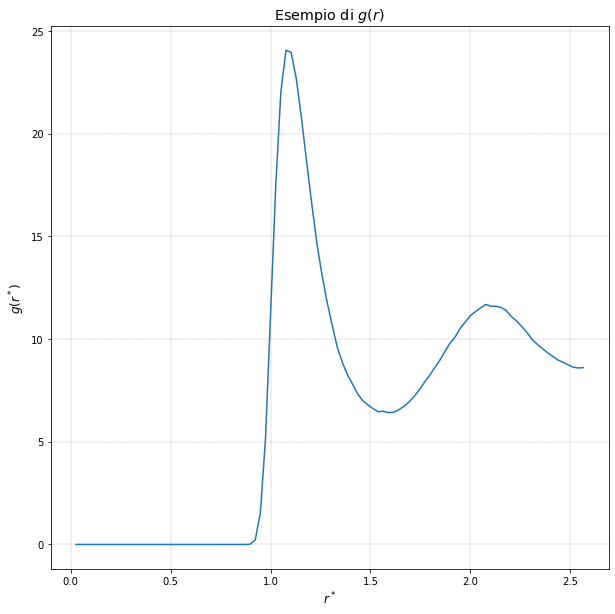

In [6]:
#g(r)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
r, gofr, err_gofr = np.loadtxt("MonteCarlo_NVT/Data/output.gave.0", usecols=(1,2,3), unpack=True)

ax.plot(r,gofr)
ax.set_xlabel(r'$r^*$', fontsize='large')
ax.set_ylabel(r'$g(r^*)$', fontsize='large')
ax.set_title(r'Esempio di $g(r)$', fontsize='x-large')
ax.grid(True, linestyle="--", linewidth=0.2, color='.25', zorder=-10)

plt.show()

### Esercizio 07.4
Procediamo ora con le simulazioni che forniranno le stime dei valori di energia e pressione, e il profilo della $g(r)$.

Le condizioni termodinamiche dell'Argon che simuliamo sono le seguenti:

- Fase solida: $\rho^\star = 1.1$, $T^\star = 0.8$ (raggio di cut-off: $r_c = 2.2$)
- Fase liquida: $\rho^\star = 0.8$, $T^\star = 1.1$ (raggio di cut-off: $r_c = 2.5$)
- Fase gassosa: $\rho^\star = 0.05$, $T^\star = 1.2$ (raggio di cut-off: $r_c = 5.0$)

Il sistema è composto da $108$ particelle; per ognuna delle tre simulazioni, il passo dell'algoritmo di Metropolis è stato scelto in modo da avere un rate di accettazione intorno al $50\%$ (nel caso del gas si è arrivati al $61\%$).

I dati sono elaborati tramite *data blocking* per calcolare valore medio ed errore statistico; ogni simulazione è divisa in $100$ blocchi, in ogni blocco sono effettuati $2000$ *step* (calcolo di un nuova configurazione del sistema e misura delle quantità di interesse). Le analisi effettuate nelle sezioni precedenti ci garantiscono che questa lunghezza dei blocchi è sufficente per avere una bassa correlazione e un errore statistico stabile.

Ogni simulazione è stata equlibrata prima di effettuare le misurazioni: si lascia evolvere il sistema per un numero sufficente di *step* fino a quando non si raggiungono valori stabili delle grandezze misurate. L'individuazione del numero minimo di step per raggiungere quesa condizione viene fatto osservando direttamente le grandezze misurate.

Di seguito riportiamo i risultati ottenuti, espressi in unità $SI$.

In [8]:
#LJ units for Argon
sigma = 0.34e-9 #m^3
Kb=8.617333262145e-5 #ev
epsilon = 120*Kb    #eV
ev = 1.602176634e-19
m = 39.948*1.66054e-27 #amu

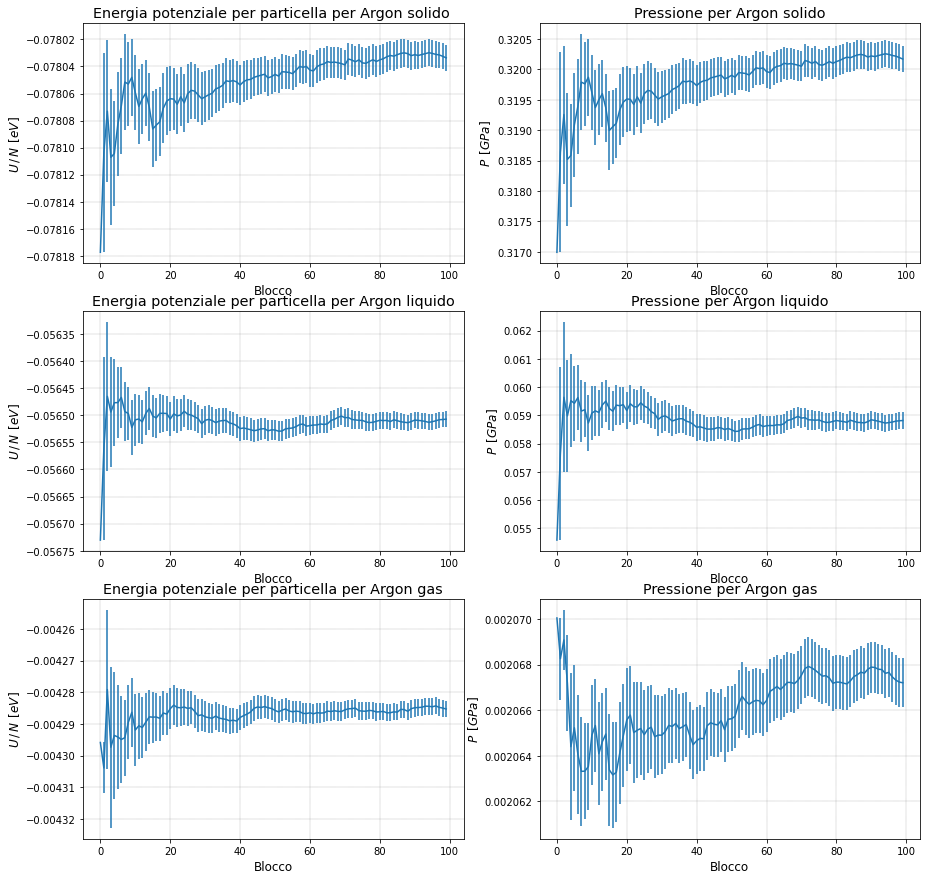

In [9]:
fig1, axs = plt.subplots(nrows=3, ncols=2, figsize=(15,15))

n_blocks = 100
x = np.arange(n_blocks)

epot = np.zeros(n_blocks)
pres = np.zeros(n_blocks)

epot_err = np.zeros(n_blocks)
pres_err = np.zeros(n_blocks)

# ============= Solid NVT ==============

file_epot = open("07.4/Solid_NVT/Data/output.epot.0")
file_pres = open("07.4/Solid_NVT/Data/output.pres.0")

epot, epot_err = np.loadtxt(file_epot, usecols=(2,3), unpack=True)
pres, pres_err = np.loadtxt(file_pres, usecols=(2,3), unpack=True)
    
file_epot.close()
file_pres.close()

#Data in SI units

epot*=epsilon
epot_err*=epsilon

pres*=epsilon/sigma**3 * ev / (10**9)
pres_err*=epsilon/sigma**3 * ev / (10**9)


#E Pot
axs[0,0].errorbar(x,epot,yerr=epot_err)
axs[0,0].set_xlabel('Blocco', fontsize='large')
axs[0,0].set_ylabel('$U\,/\,N \:\:[eV]$', fontsize='large')
axs[0,0].set_title('Energia potenziale per particella per Argon solido ', fontsize='x-large')
axs[0,0].grid(True, linestyle="--", linewidth=0.2, color='.25', zorder=-10)

#Pres
axs[0,1].errorbar(x,pres,yerr=pres_err)
axs[0,1].set_xlabel('Blocco', fontsize='large')
axs[0,1].set_ylabel('$P \:\:[GPa]$', fontsize='large')
axs[0,1].set_title('Pressione per Argon solido', fontsize='x-large')
axs[0,1].grid(True, linestyle="--", linewidth=0.2, color='.25', zorder=-10)


# ============= Liquid NVT ==============

file_epot = open("07.4/Liquid_NVT/Data/output.epot.0")
file_pres = open("07.4/Liquid_NVT/Data/output.pres.0")

epot, epot_err = np.loadtxt(file_epot, usecols=(2,3), unpack=True)
pres, pres_err = np.loadtxt(file_pres, usecols=(2,3), unpack=True)
    
file_epot.close()
file_pres.close()

#Data in SI units

epot*=epsilon
epot_err*=epsilon

pres*=epsilon/sigma**3 * ev / (10**9)
pres_err*=epsilon/sigma**3 * ev / (10**9)


#E Pot
axs[1,0].errorbar(x,epot,yerr=epot_err)
axs[1,0].set_xlabel('Blocco', fontsize='large')
axs[1,0].set_ylabel('$U\,/\,N \:\:[eV]$', fontsize='large')
axs[1,0].set_title('Energia potenziale per particella per Argon liquido', fontsize='x-large')
axs[1,0].grid(True, linestyle="--", linewidth=0.2, color='.25', zorder=-10)

#Pres
axs[1,1].errorbar(x,pres,yerr=pres_err)
axs[1,1].set_xlabel('Blocco', fontsize='large')
axs[1,1].set_ylabel('$P \:\:[GPa]$', fontsize='large')
axs[1,1].set_title('Pressione per Argon liquido', fontsize='x-large')
axs[1,1].grid(True, linestyle="--", linewidth=0.2, color='.25', zorder=-10)


# ============= Gas NVT ==============

file_epot = open("07.4/Gas_NVT/Data/output.epot.0")
file_pres = open("07.4/Gas_NVT/Data/output.pres.0")

epot, epot_err = np.loadtxt(file_epot, usecols=(2,3), unpack=True)
pres, pres_err = np.loadtxt(file_pres, usecols=(2,3), unpack=True)
    
file_epot.close()
file_pres.close()

#Data in SI units

epot*=epsilon
epot_err*=epsilon

pres*=epsilon/sigma**3 * ev / (10**9)
pres_err*=epsilon/sigma**3 * ev / (10**9)


#E Pot
axs[2,0].errorbar(x,epot,yerr=epot_err)
axs[2,0].set_xlabel('Blocco', fontsize='large')
axs[2,0].set_ylabel('$U\,/\,N \:\:[eV]$', fontsize='large')
axs[2,0].set_title('Energia potenziale per particella per Argon gas', fontsize='x-large')
axs[2,0].grid(True, linestyle="--", linewidth=0.2, color='.25', zorder=-10)

#Pres
axs[2,1].errorbar(x,pres,yerr=pres_err)
axs[2,1].set_xlabel('Blocco', fontsize='large')
axs[2,1].set_ylabel('$P \:\:[GPa]$', fontsize='large')
axs[2,1].set_title('Pressione per Argon gas', fontsize='x-large')
axs[2,1].grid(True, linestyle="--", linewidth=0.2, color='.25', zorder=-10)

plt.show()

I risultati mostrano una covergenza ad un valore stabile in quasi tutti i casi; si nota come il comportamento di pressione ed energia potenziale siano simili, meno che nel caso della fase gassosa.

Riportiamo anche la $g(r)$, calcolata sia col codice *NVE* che con quello *NVT*; anche nel caso del codice *NVE* il sistema è stato equlibrato (v. *Esercitazione 4*).

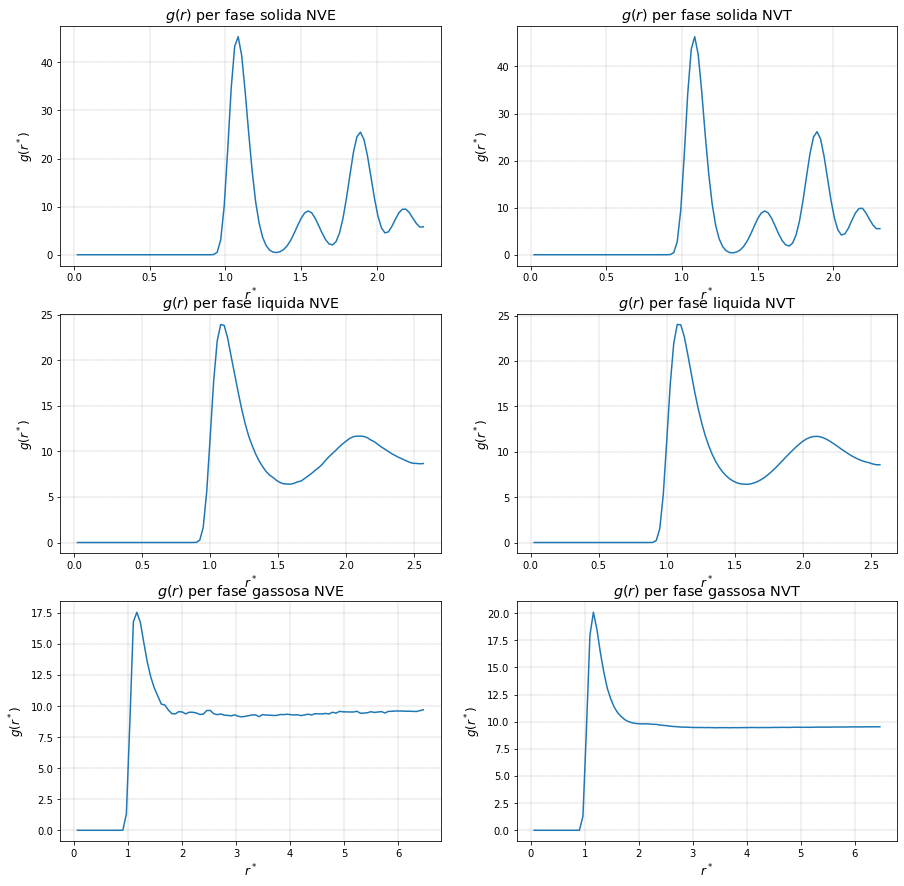

In [4]:
# g(r)

fig1, axs = plt.subplots(nrows=3, ncols=2, figsize=(15,15))

# Solid
r_NVE, gofr_NVE, err_gofr_NVE = np.loadtxt("07.4/Solid_NVE/Data/output.gave.0", usecols=(1,2,3), unpack=True)
r_NVT, gofr_NVT, err_gofr_NVT = np.loadtxt("07.4/Solid_NVT/Data/output.gave.0", usecols=(1,2,3), unpack=True)

#NVE Solid
axs[0,0].plot(r_NVE, gofr_NVE)
axs[0,0].set_xlabel(r'$r^*$', fontsize='large')
axs[0,0].set_ylabel(r'$g(r^*)$', fontsize='large')
axs[0,0].set_title(r'$g(r)$ per fase solida NVE', fontsize='x-large')
axs[0,0].grid(True, linestyle="--", linewidth=0.2, color='.25', zorder=-10)

#NVT Solid
axs[0,1].plot(r_NVT, gofr_NVT)
axs[0,1].set_xlabel(r'$r^*$', fontsize='large')
axs[0,1].set_ylabel(r'$g(r^*)$', fontsize='large')
axs[0,1].set_title(r'$g(r)$ per fase solida NVT', fontsize='x-large')
axs[0,1].grid(True, linestyle="--", linewidth=0.2, color='.25', zorder=-10)


# Liquid
r_NVE, gofr_NVE, err_gofr_NVE = np.loadtxt("07.4/Liquid_NVE/Data/output.gave.0", usecols=(1,2,3), unpack=True)
r_NVT, gofr_NVT, err_gofr_NVT = np.loadtxt("07.4/Liquid_NVT/Data/output.gave.0", usecols=(1,2,3), unpack=True)

#NVE liquid
axs[1,0].plot(r_NVE, gofr_NVE)
axs[1,0].set_xlabel(r'$r^*$', fontsize='large')
axs[1,0].set_ylabel(r'$g(r^*)$', fontsize='large')
axs[1,0].set_title(r'$g(r)$ per fase liquida NVE', fontsize='x-large')
axs[1,0].grid(True, linestyle="--", linewidth=0.2, color='.25', zorder=-10)

#NVT liquid
axs[1,1].plot(r_NVT, gofr_NVT)
axs[1,1].set_xlabel(r'$r^*$', fontsize='large')
axs[1,1].set_ylabel(r'$g(r^*)$', fontsize='large')
axs[1,1].set_title(r'$g(r)$ per fase liquida NVT', fontsize='x-large')
axs[1,1].grid(True, linestyle="--", linewidth=0.2, color='.25', zorder=-10)


# Gas
r_NVE, gofr_NVE, err_gofr_NVE = np.loadtxt("07.4/Gas_NVE/Data/output.gave.0", usecols=(1,2,3), unpack=True)
r_NVT, gofr_NVT, err_gofr_NVT = np.loadtxt("07.4/Gas_NVT/Data/output.gave.0", usecols=(1,2,3), unpack=True)

#NVE gas
axs[2,0].plot(r_NVE, gofr_NVE)
axs[2,0].set_xlabel(r'$r^*$', fontsize='large')
axs[2,0].set_ylabel(r'$g(r^*)$', fontsize='large')
axs[2,0].set_title(r'$g(r)$ per fase gassosa NVE', fontsize='x-large')
axs[2,0].grid(True, linestyle="--", linewidth=0.2, color='.25', zorder=-10)

#NVT gas
axs[2,1].plot(r_NVT, gofr_NVT)
axs[2,1].set_xlabel(r'$r^*$', fontsize='large')
axs[2,1].set_ylabel(r'$g(r^*)$', fontsize='large')
axs[2,1].set_title(r'$g(r)$ per fase gassosa NVT', fontsize='x-large')
axs[2,1].grid(True, linestyle="--", linewidth=0.2, color='.25', zorder=-10)

plt.show()

Si vede come il profilo della funzione sia lo stesso per entrambi i codici; quindi il calcolo effettuato nei due *ensemble* (canonico e microcanonico) ha portato allo stesso risulatato, nonostante i due codici utilizzino approcci diversi per simulare il sistema (algoritmo deterministico per *NVE*, metodo Monte Carlo per *NVT*).

In [ ]:
s